In [17]:
import pandas as pd

df_ben_ddos = pd.read_csv('df_ben_ddos.csv')
df_ben_ddos



,id.orig_addr,id.orig_port,id.resp_haddr,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes,Category
0,1098,48438,12963,23,1,5.030600,4,1,60,0,0,0
1,1098,33878,59500,23,1,3.089012,4,3,180,0,0,0
2,1098,55416,62742,23,1,3.089276,4,3,180,0,0,0
3,1098,47778,11680,23,1,5.030600,4,1,60,0,0,0
4,1098,46752,1504,23,1,3.130498,4,3,180,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2314090,1097,59699,22203,62336,1,5.030600,0,0,0,0,0,1
2314091,1097,32909,22203,62336,1,5.030600,0,0,0,0,0,1
2314092,1097,25120,22203,62336,1,5.030600,0,0,0,0,0,1
2314093,1097,30340,22203,62336,1,5.030600,0,0,0,0,0,1


In [18]:
df_first = df_ben_ddos[:70000].sample(n=500, random_state=42)
df_last = df_ben_ddos[80000:].sample(n=500, random_state=42)
df_sampled = pd.concat([df_first, df_last], ignore_index=True)
df_sampled

,id.orig_addr,id.orig_port,id.resp_haddr,id.resp_pport,proto_enum,duration_interval,conn_state_string,orig_pkts_count,orig_ip_bytes_count,resp_pkts_count,resp_bytes,Category
0,1227,5151,6991,53,2,5.030600,4,1,540,0,0,0
1,1227,61215,51455,53,2,5.030600,4,1,540,0,0,0
2,1227,60587,64840,53,2,5.030600,4,1,540,0,0,0
3,1098,52092,10766,23,1,3.119981,4,3,180,0,0,0
4,1227,5566,41839,53,2,5.030600,4,1,540,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1098,56337,52879,992,1,4.894192,3,5,200,0,0,1
996,1098,38377,52879,992,1,2.417121,3,5,200,0,0,1
997,1098,9529,37595,22,1,5.030600,0,56,2800,0,0,1
998,1098,60214,52879,992,1,3.827053,3,3,120,0,0,1


In [19]:
# Separate features and target labels
X = df_sampled.drop(columns=['Category'])
y = df_sampled['Category']

Best hyperparameters for this fold: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy for this fold: 0.998
Best hyperparameters for this fold: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy for this fold: 1.0

Cross-validated outer accuracy scores: [0.998, 1.0]
Mean accuracy: 0.999
Standard deviation of accuracy: 0.0010000000000000009


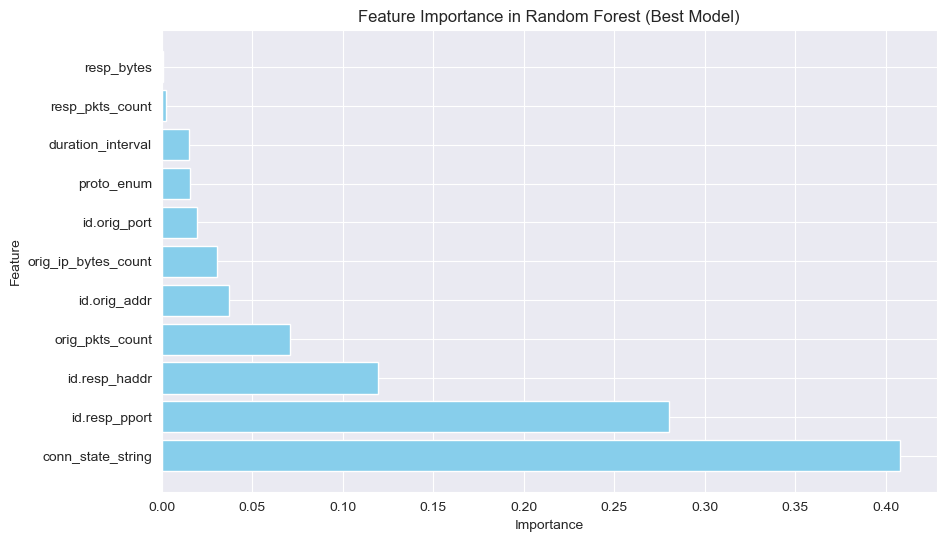

In [21]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have X (features) and y (target) already defined
# Example of X and y for illustration (replace with your actual dataset)
# X = pd.DataFrame(...)  # your feature DataFrame
# y = pd.Series(...)  # your target Series

# Initialize the outer cross-validation
outer_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Define parameter grid for Random Forest hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# List to hold the accuracy scores from the outer CV loop
outer_scores = []
best_model = None

# Outer cross-validation loop
for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Define inner cross-validation for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

    # Initialize Random Forest model
    rf_model = RandomForestClassifier(random_state=42)

    # GridSearchCV for hyperparameter tuning within the inner CV loop
    grid_search = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid,
        cv=inner_cv,
        scoring='accuracy',
        n_jobs=-1
    )

    # Fit GridSearchCV on the training data of the current outer fold
    grid_search.fit(X_train, y_train)

    # Select the best model from the inner CV tuning
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the outer fold test set
    y_pred = best_model.predict(X_test)
    outer_accuracy = accuracy_score(y_test, y_pred)
    outer_scores.append(outer_accuracy)

    print(f"Best hyperparameters for this fold: {grid_search.best_params_}")
    print(f"Accuracy for this fold: {outer_accuracy}")

# Calculate and print the final results from the outer cross-validation loop
print("\nCross-validated outer accuracy scores:", outer_scores)
print("Mean accuracy:", np.mean(outer_scores))
print("Standard deviation of accuracy:", np.std(outer_scores))

# After the outer CV loop, get the feature importance of the best model
importances = best_model.feature_importances_

# Create a DataFrame for easy plotting
feature_importances = pd.DataFrame({
    'feature': X.columns,  # assuming X is a DataFrame
    'importance': importances
})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest (Best Model)')
plt.show()
